## Astra Zeneca

In [1]:
# DataFrame
import numpy as np
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Collections
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
azn_sent_df = pd.read_csv('../AvgDailySent/astra_daily_avg_sent.csv')
azn_sent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   created_at  484 non-null    object 
 1   sentiment   465 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.7+ KB


In [3]:
azn_sent_df.head()

,created_at,sentiment
0,2021-01-01 00:00:00+00:00,0.666667
1,2021-01-02 00:00:00+00:00,1.000000
2,2021-01-03 00:00:00+00:00,1.000000
3,2021-01-04 00:00:00+00:00,1.363636
4,2021-01-05 00:00:00+00:00,0.800000


In [4]:
# Convert date column to datetime.
azn_sent_df['created_at'] = pd.to_datetime(azn_sent_df['created_at']).dt.tz_localize(None)
azn_sent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   created_at  484 non-null    datetime64[ns]
 1   sentiment   465 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.7 KB


In [5]:
# Assign target value.
azn_sent_df.loc[azn_sent_df['sentiment'] < 1.0, 'sentiment'] = 0.0
azn_sent_df.loc[azn_sent_df['sentiment'] > 1.0, 'sentiment'] = 2.0
azn_sent_df

,created_at,sentiment
0,2021-01-01,0.0
1,2021-01-02,1.0
2,2021-01-03,1.0
3,2021-01-04,2.0
4,2021-01-05,0.0
...,...,...
479,2022-04-25,1.0
480,2022-04-26,1.0
481,2022-04-27,0.0
482,2022-04-28,2.0


Text(0.5, 1.0, 'AstraZeneca daily sentiment labels distribuition')

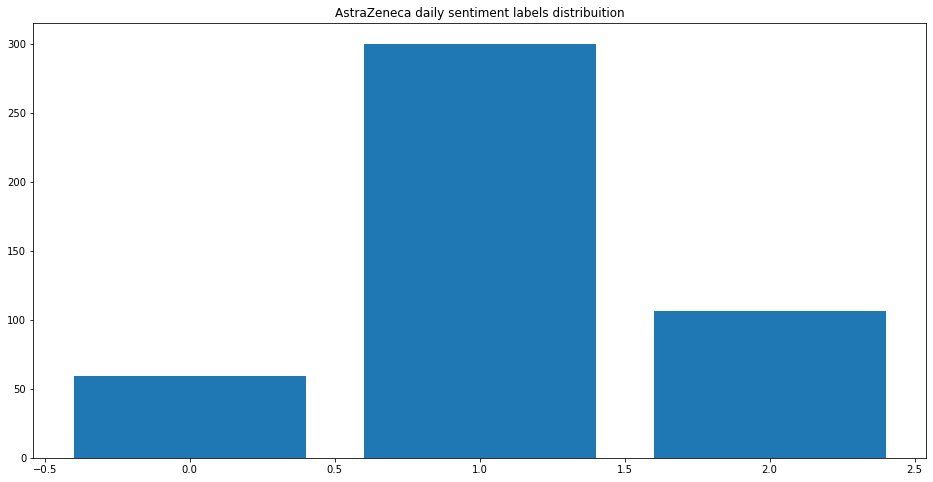

In [6]:
target_count = Counter(azn_sent_df.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_count.keys(), target_count.values())
plt.title("AstraZeneca daily sentiment labels distribuition")

In [7]:
azn_sent_df['sentiment'].value_counts()    

1.0    197
2.0    169
0.0    114
Name: sentiment, dtype: int64

### Load stock data

In [7]:
azn_stock_df = pd.read_csv('../StockData/AZN.L.csv')
azn_stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,7425.0,7560.00000,7402.5,7422.0,7054.458496,4373741
1,2021-01-05,7445.0,7484.60791,7366.0,7439.0,7070.616699,2800020
2,2021-01-06,7407.0,7583.00000,7375.0,7512.0,7140.001953,2567664
3,2021-01-07,7575.0,7583.00000,7404.0,7475.0,7104.833984,2874639
4,2021-01-08,7444.0,7499.00000,7398.0,7471.0,7101.032227,3028898


In [8]:
azn_stock_df = azn_stock_df.rename({'Date': 'created_at'}, axis=1)
azn_stock_df.head()

,created_at,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,7425.0,7560.00000,7402.5,7422.0,7054.458496,4373741
1,2021-01-05,7445.0,7484.60791,7366.0,7439.0,7070.616699,2800020
2,2021-01-06,7407.0,7583.00000,7375.0,7512.0,7140.001953,2567664
3,2021-01-07,7575.0,7583.00000,7404.0,7475.0,7104.833984,2874639
4,2021-01-08,7444.0,7499.00000,7398.0,7471.0,7101.032227,3028898


In [9]:
# Finetune the date such that sentiment for the previous day is assigned to the stock price of the current day.
azn_sent_df['created_at'] = azn_sent_df['created_at'] + pd.Timedelta(days=1)
azn_sent_df.head()

,created_at,sentiment
0,2021-01-02,0.0
1,2021-01-03,1.0
2,2021-01-04,1.0
3,2021-01-05,2.0
4,2021-01-06,0.0


In [10]:
# Convert date column to datetime.
azn_stock_df['created_at'] = pd.to_datetime(azn_stock_df['created_at']).dt.tz_localize(None)

In [11]:
merged = pd.merge(azn_stock_df, azn_sent_df, on='created_at')
merged.head()

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2021-01-04,7425.0,7560.00000,7402.5,7422.0,7054.458496,4373741,1.0
1,2021-01-05,7445.0,7484.60791,7366.0,7439.0,7070.616699,2800020,2.0
2,2021-01-06,7407.0,7583.00000,7375.0,7512.0,7140.001953,2567664,0.0
3,2021-01-07,7575.0,7583.00000,7404.0,7475.0,7104.833984,2874639,2.0
4,2021-01-08,7444.0,7499.00000,7398.0,7471.0,7101.032227,3028898,1.0


In [12]:
merged['sentiment'].value_counts()

1.0    209
2.0     75
0.0     40
Name: sentiment, dtype: int64

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [14]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(merged[['sentiment']])
merged['sentiment'] = imputer.transform(merged[['sentiment']])
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   created_at  335 non-null    datetime64[ns]
 1   Open        335 non-null    float64       
 2   High        335 non-null    float64       
 3   Low         335 non-null    float64       
 4   Close       335 non-null    float64       
 5   Adj Close   335 non-null    float64       
 6   Volume      335 non-null    int64         
 7   sentiment   335 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 23.6 KB


In [15]:
merged['sentiment'].value_counts()

1.0    220
2.0     75
0.0     40
Name: sentiment, dtype: int64

In [16]:
merged['trend'] = merged['Close'] - merged['Open']
merged.head()

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend
0,2021-01-04,7425.0,7560.00000,7402.5,7422.0,7054.458496,4373741,1.0,-3.0
1,2021-01-05,7445.0,7484.60791,7366.0,7439.0,7070.616699,2800020,2.0,-6.0
2,2021-01-06,7407.0,7583.00000,7375.0,7512.0,7140.001953,2567664,0.0,105.0
3,2021-01-07,7575.0,7583.00000,7404.0,7475.0,7104.833984,2874639,2.0,-100.0
4,2021-01-08,7444.0,7499.00000,7398.0,7471.0,7101.032227,3028898,1.0,27.0


In [17]:
merged.loc[merged['trend'] < 0, 'Trend'] = 'Negative'
merged.loc[merged['trend'] > 0, 'Trend'] = 'Positive'
merged.loc[merged['trend'] == 0, 'Trend'] = 'Neutral'
merged.head()

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,Trend
0,2021-01-04,7425.0,7560.00000,7402.5,7422.0,7054.458496,4373741,1.0,-3.0,Negative
1,2021-01-05,7445.0,7484.60791,7366.0,7439.0,7070.616699,2800020,2.0,-6.0,Negative
2,2021-01-06,7407.0,7583.00000,7375.0,7512.0,7140.001953,2567664,0.0,105.0,Positive
3,2021-01-07,7575.0,7583.00000,7404.0,7475.0,7104.833984,2874639,2.0,-100.0,Negative
4,2021-01-08,7444.0,7499.00000,7398.0,7471.0,7101.032227,3028898,1.0,27.0,Positive


In [18]:
merged['Trend'].value_counts()

Positive    183
Negative    151
Neutral       1
Name: Trend, dtype: int64

In [19]:
merged.drop(['trend'], axis=1, inplace=True)
merged.rename({'Trend': 'trend'}, axis=1, inplace=True)
merged.head()

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend
0,2021-01-04,7425.0,7560.00000,7402.5,7422.0,7054.458496,4373741,1.0,Negative
1,2021-01-05,7445.0,7484.60791,7366.0,7439.0,7070.616699,2800020,2.0,Negative
2,2021-01-06,7407.0,7583.00000,7375.0,7512.0,7140.001953,2567664,0.0,Positive
3,2021-01-07,7575.0,7583.00000,7404.0,7475.0,7104.833984,2874639,2.0,Negative
4,2021-01-08,7444.0,7499.00000,7398.0,7471.0,7101.032227,3028898,1.0,Positive


In [20]:
future_trend = merged['Close'].diff(periods=5)
merged['future_trend'] = future_trend
merged.head(10)

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend
0,2021-01-04,7425.0,7560.000000,7402.5,7422.0,7054.458496,4373741,1.0,Negative,NaN
1,2021-01-05,7445.0,7484.607910,7366.0,7439.0,7070.616699,2800020,2.0,Negative,NaN
2,2021-01-06,7407.0,7583.000000,7375.0,7512.0,7140.001953,2567664,0.0,Positive,NaN
3,2021-01-07,7575.0,7583.000000,7404.0,7475.0,7104.833984,2874639,2.0,Negative,NaN
4,2021-01-08,7444.0,7499.000000,7398.0,7471.0,7101.032227,3028898,1.0,Positive,NaN
5,2021-01-11,7492.0,7605.209961,7483.0,7556.0,7181.823242,1728696,1.0,Positive,134.0
6,2021-01-12,7498.0,7498.000000,7396.0,7405.0,7038.300781,2085461,1.0,Negative,-34.0
7,2021-01-13,7388.0,7529.000000,7380.0,7529.0,7156.160156,3474528,1.0,Positive,17.0
8,2021-01-14,7480.0,7599.189941,7449.0,7559.0,7184.674805,4881492,0.0,Positive,84.0
9,2021-01-15,7533.0,7592.000000,7503.0,7592.0,7216.040039,4424316,1.0,Positive,121.0


In [21]:
merged.loc[merged['future_trend'] < 0, 'Trend'] = 'Negative'
merged.loc[merged['future_trend'] > 0, 'Trend'] = 'Positive'
merged.loc[merged['future_trend'] == 0, 'Trend'] = 'Neutral'
merged.head(10)

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,Trend
0,2021-01-04,7425.0,7560.000000,7402.5,7422.0,7054.458496,4373741,1.0,Negative,NaN,NaN
1,2021-01-05,7445.0,7484.607910,7366.0,7439.0,7070.616699,2800020,2.0,Negative,NaN,NaN
2,2021-01-06,7407.0,7583.000000,7375.0,7512.0,7140.001953,2567664,0.0,Positive,NaN,NaN
3,2021-01-07,7575.0,7583.000000,7404.0,7475.0,7104.833984,2874639,2.0,Negative,NaN,NaN
4,2021-01-08,7444.0,7499.000000,7398.0,7471.0,7101.032227,3028898,1.0,Positive,NaN,NaN
5,2021-01-11,7492.0,7605.209961,7483.0,7556.0,7181.823242,1728696,1.0,Positive,134.0,Positive
6,2021-01-12,7498.0,7498.000000,7396.0,7405.0,7038.300781,2085461,1.0,Negative,-34.0,Negative
7,2021-01-13,7388.0,7529.000000,7380.0,7529.0,7156.160156,3474528,1.0,Positive,17.0,Positive
8,2021-01-14,7480.0,7599.189941,7449.0,7559.0,7184.674805,4881492,0.0,Positive,84.0,Positive
9,2021-01-15,7533.0,7592.000000,7503.0,7592.0,7216.040039,4424316,1.0,Positive,121.0,Positive


In [22]:
merged.drop(['future_trend'], axis=1, inplace=True)
merged.rename({'Trend': 'future_trend'}, axis=1, inplace=True)

In [23]:
merged.head(10)

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend
0,2021-01-04,7425.0,7560.000000,7402.5,7422.0,7054.458496,4373741,1.0,Negative,NaN
1,2021-01-05,7445.0,7484.607910,7366.0,7439.0,7070.616699,2800020,2.0,Negative,NaN
2,2021-01-06,7407.0,7583.000000,7375.0,7512.0,7140.001953,2567664,0.0,Positive,NaN
3,2021-01-07,7575.0,7583.000000,7404.0,7475.0,7104.833984,2874639,2.0,Negative,NaN
4,2021-01-08,7444.0,7499.000000,7398.0,7471.0,7101.032227,3028898,1.0,Positive,NaN
5,2021-01-11,7492.0,7605.209961,7483.0,7556.0,7181.823242,1728696,1.0,Positive,Positive
6,2021-01-12,7498.0,7498.000000,7396.0,7405.0,7038.300781,2085461,1.0,Negative,Negative
7,2021-01-13,7388.0,7529.000000,7380.0,7529.0,7156.160156,3474528,1.0,Positive,Positive
8,2021-01-14,7480.0,7599.189941,7449.0,7559.0,7184.674805,4881492,0.0,Positive,Positive
9,2021-01-15,7533.0,7592.000000,7503.0,7592.0,7216.040039,4424316,1.0,Positive,Positive


### Moving Averages

In [24]:
sma_5 = merged['Close'].rolling(5).mean().shift()
ema_5 = merged['Close'].ewm(5).mean().shift()

In [25]:
merged['sma_5'] = sma_5
merged['ema_5'] = ema_5
merged.head(10)

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,sma_5,ema_5
0,2021-01-04,7425.0,7560.000000,7402.5,7422.0,7054.458496,4373741,1.0,Negative,NaN,NaN,NaN
1,2021-01-05,7445.0,7484.607910,7366.0,7439.0,7070.616699,2800020,2.0,Negative,NaN,NaN,7422.000000
2,2021-01-06,7407.0,7583.000000,7375.0,7512.0,7140.001953,2567664,0.0,Positive,NaN,NaN,7431.272727
3,2021-01-07,7575.0,7583.000000,7404.0,7475.0,7104.833984,2874639,2.0,Negative,NaN,NaN,7463.208791
4,2021-01-08,7444.0,7499.000000,7398.0,7471.0,7101.032227,3028898,1.0,Positive,NaN,NaN,7467.004471
5,2021-01-11,7492.0,7605.209961,7483.0,7556.0,7181.823242,1728696,1.0,Positive,Positive,7463.8,7468.117824
6,2021-01-12,7498.0,7498.000000,7396.0,7405.0,7038.300781,2085461,1.0,Negative,Negative,7490.6,7490.140053
7,2021-01-13,7388.0,7529.000000,7380.0,7529.0,7156.160156,3474528,1.0,Positive,Positive,7483.8,7470.456814
8,2021-01-14,7480.0,7599.189941,7449.0,7559.0,7184.674805,4881492,0.0,Positive,Positive,7487.2,7483.170902
9,2021-01-15,7533.0,7592.000000,7503.0,7592.0,7216.040039,4424316,1.0,Positive,Positive,7504.0,7498.847270


In [26]:
merged.dropna(inplace=True)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 5 to 334
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_at    330 non-null    datetime64[ns]
 1   Open          330 non-null    float64       
 2   High          330 non-null    float64       
 3   Low           330 non-null    float64       
 4   Close         330 non-null    float64       
 5   Adj Close     330 non-null    float64       
 6   Volume        330 non-null    int64         
 7   sentiment     330 non-null    float64       
 8   trend         330 non-null    object        
 9   future_trend  330 non-null    object        
 10  sma_5         330 non-null    float64       
 11  ema_5         330 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 33.5+ KB


In [27]:
merged.set_index('created_at', inplace=True)
merged.head(10)

,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,sma_5,ema_5
created_at,,,,,,,,,,,
2021-01-11,7492.0,7605.209961,7483.000000,7556.0,7181.823242,1728696,1.0,Positive,Positive,7463.8,7468.117824
2021-01-12,7498.0,7498.000000,7396.000000,7405.0,7038.300781,2085461,1.0,Negative,Negative,7490.6,7490.140053
2021-01-13,7388.0,7529.000000,7380.000000,7529.0,7156.160156,3474528,1.0,Positive,Positive,7483.8,7470.456814
2021-01-14,7480.0,7599.189941,7449.000000,7559.0,7184.674805,4881492,0.0,Positive,Positive,7487.2,7483.170902
2021-01-15,7533.0,7592.000000,7503.000000,7592.0,7216.040039,4424316,1.0,Positive,Positive,7504.0,7498.847270
2021-01-18,7588.0,7691.000000,7563.000000,7662.0,7282.574219,2403380,1.0,Positive,Positive,7528.2,7517.363142
2021-01-19,7750.0,7801.680176,7680.000000,7722.0,7339.602539,3108910,1.0,Negative,Positive,7549.4,7545.218247
2021-01-20,7686.0,7747.000000,7635.751953,7645.0,7266.416016,2316591,1.0,Negative,Positive,7612.8,7578.403860
2021-01-21,7689.0,7747.000000,7636.000000,7650.0,7271.167969,2370049,2.0,Negative,Positive,7636.0,7590.647560


Text(0.5, 1.0, 'AstraZeneca Closing Stock Price and Moving Averages')

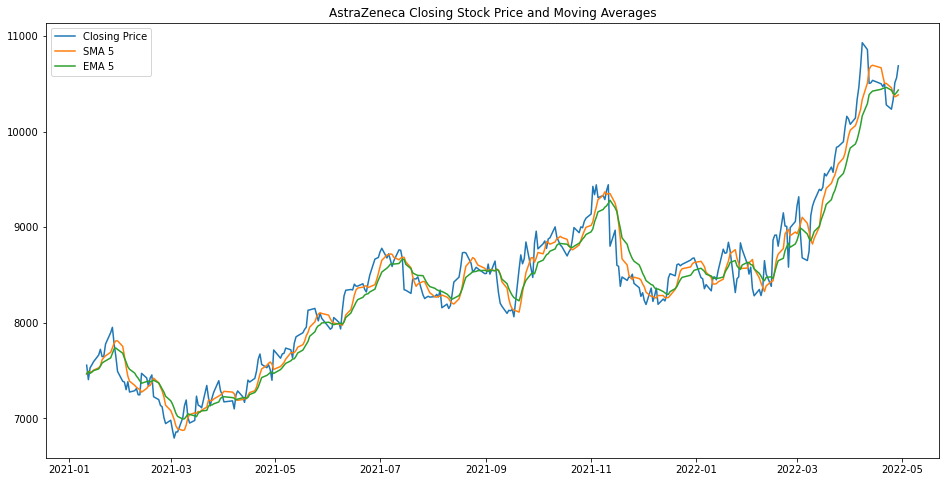

In [28]:
# Plot close price and moving averages.
plt.figure(figsize=(16,8))
plt.plot(merged['Close'], label='Closing Price')
plt.plot(merged['sma_5'], label='SMA 5')
plt.plot(merged['ema_5'], label='EMA 5')
plt.legend(loc='upper left')
plt.title('AstraZeneca Closing Stock Price and Moving Averages')

### Train - Test Split

In [31]:
test_size = 110
df_train = merged[:-test_size]
df_test = merged[-test_size:]
print('There are {} training samples and {} test samples.'.format(len(df_train), len(df_test)))

There are 220 training samples and 110 test samples.


In [32]:
def get_dummies(train_set, test_set, old_col_name):
    """Given a trainset, a testset, and the name of a column holding a 
    categorical variable, fit an encoder on the trainset, and use the 
    encoder to add dummy columns into the trainset and testset
    """
    
    one_hot_encoder = OneHotEncoder(drop="if_binary", sparse=False)
    
    cat_vals = train_set[old_col_name].values.reshape(-1,1)
    transformed = one_hot_encoder.fit_transform(cat_vals)
    
    new_col_names = one_hot_encoder.categories_[0].tolist()[1:]
    # Trainset 
    for i, new_col_name in enumerate(new_col_names):
        train_set[new_col_name] = transformed[:,i]
    
    cat_vals = test_set[old_col_name].values.reshape(-1,1)
    transformed = one_hot_encoder.transform(cat_vals)
    # Testset
    for i, new_col_name in enumerate(new_col_names):
        test_set[new_col_name] = transformed[:,i]
    
    return train_set, test_set

df_train, df_test = get_dummies(df_train, df_test, 'trend')

# check if the dummies are produced correctly in the trainset
df_train.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,sma_5,ema_5,Neutral,Positive
created_at,,,,,,,,,,,,,
2021-01-11,7492.0,7605.209961,7483.0,7556.0,7181.823242,1728696,1.0,Positive,Positive,7463.8,7468.117824,0.0,0.0
2021-01-12,7498.0,7498.000000,7396.0,7405.0,7038.300781,2085461,1.0,Negative,Negative,7490.6,7490.140053,1.0,0.0
2021-01-13,7388.0,7529.000000,7380.0,7529.0,7156.160156,3474528,1.0,Positive,Positive,7483.8,7470.456814,0.0,0.0
2021-01-14,7480.0,7599.189941,7449.0,7559.0,7184.674805,4881492,0.0,Positive,Positive,7487.2,7483.170902,0.0,0.0
2021-01-15,7533.0,7592.000000,7503.0,7592.0,7216.040039,4424316,1.0,Positive,Positive,7504.0,7498.847270,0.0,0.0


In [33]:
df_test.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,sma_5,ema_5,Neutral,Positive
created_at,,,,,,,,,,,,,
2021-11-22,8483.0,8552.0,8393.666016,8443.0,8248.148438,2069463,1.0,Negative,Negative,8604.0,8819.902448,1.0,0.0
2021-11-23,8403.0,8517.0,8351.000000,8480.0,8284.293945,1618987,1.0,Positive,Negative,8499.0,8757.085373,0.0,0.0
2021-11-24,8489.0,8518.0,8404.000000,8471.0,8275.501953,1393828,1.0,Negative,Negative,8474.6,8710.904477,1.0,0.0
2021-11-25,8495.0,8572.0,8486.754883,8508.0,8311.648438,1385060,0.0,Positive,Positive,8450.8,8670.920398,0.0,0.0
2021-11-26,8383.0,8560.0,8344.000000,8411.0,8216.886719,2355956,1.0,Positive,Negative,8476.2,8643.766998,0.0,0.0


In [34]:
df_train.drop(['trend'], axis=1, inplace=True)
df_test.drop(['trend'], axis=1, inplace=True)

In [38]:
# df_train.rename({'Positive': 'encoded_trend'}, axis=1, inplace=True)
# df_test.rename({'Positive': 'encoded_trend'}, axis=1, inplace=True)

### Training set scaling

In [35]:
scaler = StandardScaler()

trainset_target = df_train["future_trend"].values
trainset_predictors = df_train.drop("future_trend", axis=1)
scaled_vals = scaler.fit_transform(trainset_predictors)
df_train = pd.DataFrame(scaled_vals, columns=trainset_predictors.columns)

# Put non-scaled target variable back into the dataframe
df_train['future_trend'] = trainset_target

# inspect the data
df_train.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment,sma_5,ema_5,Neutral,Positive,future_trend
0,-0.877657,-0.843267,-0.773246,-0.791780,-0.949913,-0.270662,-0.108911,-0.918487,-0.909652,-0.904534,-0.067574,Positive
1,-0.868554,-1.006007,-0.904864,-1.020638,-1.160145,-0.182238,-0.108911,-0.877480,-0.874754,1.105542,-0.067574,Negative
2,-1.035437,-0.958950,-0.929070,-0.832701,-0.987504,0.162041,-0.108911,-0.887885,-0.905946,-0.904534,-0.067574,Positive
3,-0.895862,-0.852405,-0.824683,-0.787233,-0.945736,0.510757,-1.820364,-0.882682,-0.885798,-0.904534,-0.067574,Positive
4,-0.815455,-0.863319,-0.742989,-0.737217,-0.899792,0.397446,-0.108911,-0.856977,-0.860955,-0.904534,-0.067574,Positive


### Testing set scaling

In [36]:
testset_target = df_test["future_trend"].values
testset_predictors = df_test.drop("future_trend", axis=1)

# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
scaled_vals = scaler.transform(testset_predictors)
df_test = pd.DataFrame(scaled_vals, columns=testset_predictors.columns)

# Put non-scaled target variable back into the dataframe
df_test['future_trend'] = testset_target

# inspect the data
df_test.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment,sma_5,ema_5,Neutral,Positive,future_trend
0,0.625802,0.593912,0.604452,0.552574,0.612042,-0.186203,-0.108911,0.826138,1.232536,1.105542,-0.067574,Negative
1,0.504433,0.540784,0.539905,0.608652,0.664988,-0.297854,-0.108911,0.665477,1.132989,-0.904534,-0.067574,Negative
2,0.634905,0.542302,0.620086,0.595011,0.652110,-0.353659,-0.108911,0.628143,1.059806,1.105542,-0.067574,Negative
3,0.644008,0.624271,0.745281,0.651089,0.705057,-0.355832,-1.820364,0.591726,0.996442,-0.904534,-0.067574,Positive
4,0.474091,0.606056,0.529315,0.504074,0.566250,-0.115196,-0.108911,0.630591,0.953412,-0.904534,-0.067574,Negative


In [37]:
X_train = df_train.drop('future_trend', axis=1)
y_train = df_train['future_trend'].copy()

### Baseline

In [38]:
y_train.value_counts()

Positive    126
Negative     94
Name: future_trend, dtype: int64

The baseline classifier will output "Positive" for all predictions. We will use macro-averaging in this project (precision, recall and F-score are evaluated in each class separately and then averaged across classes).

So if we apply the baseline classifier to all of the training set. 

For the "Positive" label, the accuracy measures will be:

* Precision: 126/220 = 0.573

* Recall: 126/220 = 1.0

* F-score: 2/(1/precision + 1/recall) = 0.728

For the "Negative" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/94 = 0.0

* F-score: 0.0

The averages of the two classes, i.e. the eventual baseline scores:

* **Precision: 0.286**

* **Recall: 0.5**

* **F-score: 0.364**

### Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier
import time

rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 3 x 2 = 24 combinations in the grid
param_grid = {
    'n_estimators': [10, 100, 200, 1000],
    'max_depth': [3, 5, 15],
    'min_samples_split': [5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=10,
                           scoring='accuracy', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 120.14579677581787 seconds


In [40]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, random_state=7)

In [41]:
grid_search.best_score_

0.7045454545454545

In [42]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
17,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}",0.992929,0.704545,29.043744
16,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 10}",0.984343,0.700000,28.886609
19,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 1000}",0.997980,0.695455,30.313765
23,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 1000}",0.964646,0.686364,28.848168
18,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}",0.996970,0.681818,31.610942
9,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}",0.958586,0.681818,28.872497
11,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}",0.957071,0.681818,28.759894
22,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}",0.966667,0.672727,30.407524
15,"{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 1000}",0.943939,0.672727,28.731942
21,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}",0.967172,0.672727,30.443864


In [43]:
feature_importances = grid_search.best_estimator_.feature_importances_

for k, v in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f"{v}: {k}")

ema_5: 0.1799983638183909
Adj Close: 0.16353411395063916
sma_5: 0.13774236935174775
Close: 0.12895381720297922
Low: 0.11057244535645551
High: 0.09898864739317186
Open: 0.08158436311508938
Volume: 0.05341584171625331
Neutral: 0.02858645922910011
sentiment: 0.01662357886617282
Positive: 0.0


In [44]:
import os
from joblib import dump

# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search.best_estimator_, 'models/azn-rf-clf.joblib')

['models/azn-rf-clf.joblib']

In [45]:
from sklearn.svm import SVC

svm = SVC(random_state=7, kernel='rbf')

# specify the hyperparameters and their values
# 5 x 3 = 15 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ["scale", "auto", 0.1],
}

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=10,
                           scoring='accuracy', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 3.3101799488067627 seconds


In [46]:
grid_search.best_score_

0.8181818181818181

In [47]:
grid_search.best_estimator_

SVC(C=10, gamma=0.1, random_state=7)

In [48]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
11,"{'C': 10, 'gamma': 0.1}",0.909091,0.818182,1.000000e+01
9,"{'C': 10, 'gamma': 'scale'}",0.909596,0.804545,1.154914e+01
13,"{'C': 100, 'gamma': 'auto'}",0.962121,0.804545,1.637795e+01
10,"{'C': 10, 'gamma': 'auto'}",0.908586,0.800000,1.195108e+01
14,"{'C': 100, 'gamma': 0.1}",0.964646,0.800000,1.706806e+01
12,"{'C': 100, 'gamma': 'scale'}",0.962626,0.795455,1.736621e+01
6,"{'C': 1, 'gamma': 'scale'}",0.819697,0.763636,6.839187e+00
7,"{'C': 1, 'gamma': 'auto'}",0.820202,0.763636,6.896552e+00
8,"{'C': 1, 'gamma': 0.1}",0.825758,0.763636,7.522936e+00
0,"{'C': 0.01, 'gamma': 'scale'}",0.572727,0.572727,3.876969e-14


In [49]:
# Save the model
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search.best_estimator_, 'models/azn-svm-rbf-clf.joblib')

['models/azn-svm-rbf-clf.joblib']

In [50]:
from joblib import load
best_svm = load("models/azn-svm-rbf-clf.joblib")
best_rf = load("models/azn-rf-clf.joblib")

In [51]:
X_test = df_test.drop("future_trend", axis=1)
y_test = df_test["future_trend"].copy()

In [52]:
ypred = best_svm.predict(X_test)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(y_test, ypred, average="macro")
print("SVM:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

SVM:
Precision: 0.5179556456152201
Recall: 0.5354090354090354
F score: 0.5237512385615201


In [53]:
accuracy_score(y_test, ypred)

0.7909090909090909

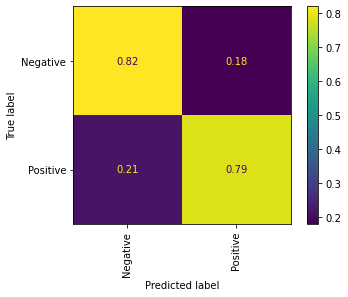

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, ypred, labels=best_svm.classes_, 
                                        xticks_rotation="vertical", normalize="true")

In [55]:
rf_ypred = best_rf.predict(X_test)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(y_test, rf_ypred, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Random Forest:
Precision: 0.5353535353535354
Recall: 0.5222222222222223
F score: 0.5264550264550264


In [56]:
accuracy_score(y_test, rf_ypred)

0.8090909090909091

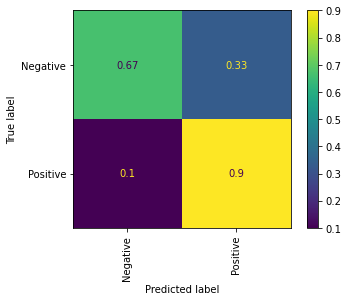

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, rf_ypred, labels=best_svm.classes_, 
                                        xticks_rotation="vertical", normalize="true")

### TSA

In [58]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [59]:
def stationary_plot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

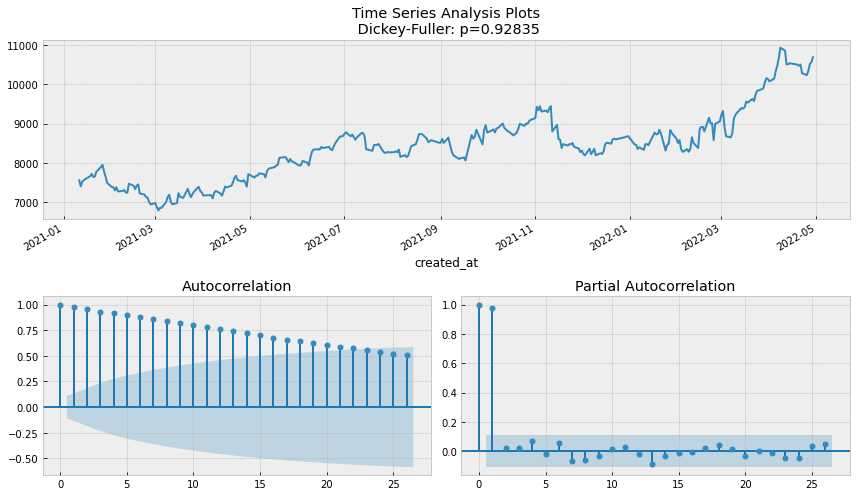

In [60]:
stationary_plot(merged["Close"])

### Testing without sentiment Variable.

In [61]:
stock_data_only = merged.drop(['sentiment'], axis=1)
stock_data_only.head()

,Open,High,Low,Close,Adj Close,Volume,trend,future_trend,sma_5,ema_5
created_at,,,,,,,,,,
2021-01-11,7492.0,7605.209961,7483.0,7556.0,7181.823242,1728696,Positive,Positive,7463.8,7468.117824
2021-01-12,7498.0,7498.000000,7396.0,7405.0,7038.300781,2085461,Negative,Negative,7490.6,7490.140053
2021-01-13,7388.0,7529.000000,7380.0,7529.0,7156.160156,3474528,Positive,Positive,7483.8,7470.456814
2021-01-14,7480.0,7599.189941,7449.0,7559.0,7184.674805,4881492,Positive,Positive,7487.2,7483.170902
2021-01-15,7533.0,7592.000000,7503.0,7592.0,7216.040039,4424316,Positive,Positive,7504.0,7498.847270


In [62]:
training_set = stock_data_only[:-test_size]
testing_set = stock_data_only[-test_size:]
print('There are {} training samples and {} test samples.'.format(len(df_train), len(df_test)))

There are 220 training samples and 110 test samples.


In [63]:
training_set.head()

,Open,High,Low,Close,Adj Close,Volume,trend,future_trend,sma_5,ema_5
created_at,,,,,,,,,,
2021-01-11,7492.0,7605.209961,7483.0,7556.0,7181.823242,1728696,Positive,Positive,7463.8,7468.117824
2021-01-12,7498.0,7498.000000,7396.0,7405.0,7038.300781,2085461,Negative,Negative,7490.6,7490.140053
2021-01-13,7388.0,7529.000000,7380.0,7529.0,7156.160156,3474528,Positive,Positive,7483.8,7470.456814
2021-01-14,7480.0,7599.189941,7449.0,7559.0,7184.674805,4881492,Positive,Positive,7487.2,7483.170902
2021-01-15,7533.0,7592.000000,7503.0,7592.0,7216.040039,4424316,Positive,Positive,7504.0,7498.847270


In [64]:
train_set, test_set = get_dummies(training_set, testing_set, 'trend')
train_set.head()

,Open,High,Low,Close,Adj Close,Volume,trend,future_trend,sma_5,ema_5,Neutral,Positive
created_at,,,,,,,,,,,,
2021-01-11,7492.0,7605.209961,7483.0,7556.0,7181.823242,1728696,Positive,Positive,7463.8,7468.117824,0.0,0.0
2021-01-12,7498.0,7498.000000,7396.0,7405.0,7038.300781,2085461,Negative,Negative,7490.6,7490.140053,1.0,0.0
2021-01-13,7388.0,7529.000000,7380.0,7529.0,7156.160156,3474528,Positive,Positive,7483.8,7470.456814,0.0,0.0
2021-01-14,7480.0,7599.189941,7449.0,7559.0,7184.674805,4881492,Positive,Positive,7487.2,7483.170902,0.0,0.0
2021-01-15,7533.0,7592.000000,7503.0,7592.0,7216.040039,4424316,Positive,Positive,7504.0,7498.847270,0.0,0.0


In [65]:
train_set.drop(['trend'], axis=1, inplace=True)
test_set.drop(['trend'], axis=1, inplace=True)

In [66]:
train_set.head()

,Open,High,Low,Close,Adj Close,Volume,future_trend,sma_5,ema_5,Neutral,Positive
created_at,,,,,,,,,,,
2021-01-11,7492.0,7605.209961,7483.0,7556.0,7181.823242,1728696,Positive,7463.8,7468.117824,0.0,0.0
2021-01-12,7498.0,7498.000000,7396.0,7405.0,7038.300781,2085461,Negative,7490.6,7490.140053,1.0,0.0
2021-01-13,7388.0,7529.000000,7380.0,7529.0,7156.160156,3474528,Positive,7483.8,7470.456814,0.0,0.0
2021-01-14,7480.0,7599.189941,7449.0,7559.0,7184.674805,4881492,Positive,7487.2,7483.170902,0.0,0.0
2021-01-15,7533.0,7592.000000,7503.0,7592.0,7216.040039,4424316,Positive,7504.0,7498.847270,0.0,0.0


Feature Scaling

In [67]:
training_target = train_set["future_trend"].values
training_predictors = train_set.drop("future_trend", axis=1)
scaled_vals = scaler.fit_transform(training_predictors)
train_set = pd.DataFrame(scaled_vals, columns=training_predictors.columns)

# Put non-scaled target variable back into the dataframe
train_set['future_trend'] = trainset_target

# inspect the data
train_set.head()

,Open,High,Low,Close,Adj Close,Volume,sma_5,ema_5,Neutral,Positive,future_trend
0,-0.877657,-0.843267,-0.773246,-0.791780,-0.949913,-0.270662,-0.918487,-0.909652,-0.904534,-0.067574,Positive
1,-0.868554,-1.006007,-0.904864,-1.020638,-1.160145,-0.182238,-0.877480,-0.874754,1.105542,-0.067574,Negative
2,-1.035437,-0.958950,-0.929070,-0.832701,-0.987504,0.162041,-0.887885,-0.905946,-0.904534,-0.067574,Positive
3,-0.895862,-0.852405,-0.824683,-0.787233,-0.945736,0.510757,-0.882682,-0.885798,-0.904534,-0.067574,Positive
4,-0.815455,-0.863319,-0.742989,-0.737217,-0.899792,0.397446,-0.856977,-0.860955,-0.904534,-0.067574,Positive


In [68]:
testing_target = test_set["future_trend"].values
testing_predictors = test_set.drop("future_trend", axis=1)
scaled_vals = scaler.fit_transform(testing_predictors)
test_set = pd.DataFrame(scaled_vals, columns=testing_predictors.columns)

# Put non-scaled target variable back into the dataframe
test_set['future_trend'] = testing_target

# inspect the data
test_set.head()

,Open,High,Low,Close,Adj Close,Volume,sma_5,ema_5,Neutral,Positive,future_trend
0,-0.718777,-0.751776,-0.720701,-0.784019,-0.797222,-0.464595,-0.543772,-0.227086,1.115750,0.0,Negative
1,-0.822074,-0.796031,-0.775544,-0.737296,-0.754280,-0.914650,-0.684801,-0.319955,-0.896258,0.0,Negative
2,-0.711029,-0.794767,-0.707417,-0.748661,-0.764725,-1.139599,-0.717573,-0.388229,1.115750,0.0,Negative
3,-0.703282,-0.726487,-0.601043,-0.701939,-0.721782,-1.148359,-0.749540,-0.447342,-0.896258,0.0,Positive
4,-0.847899,-0.741661,-0.784542,-0.824427,-0.834361,-0.178369,-0.715424,-0.487486,-0.896258,0.0,Negative


In [69]:
Xtrain = train_set.drop('future_trend', axis=1)
ytrain = train_set['future_trend'].copy()

#### Random Forest Classifier

In [70]:
rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 3 x 2 = 24 combinations in the grid
param_grid = {
    'n_estimators': [10, 100, 200, 1000],
    'max_depth': [3, 5, 15],
    'min_samples_split': [5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=10,
                           scoring='accuracy', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 120.97595191001892 seconds


In [71]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, random_state=7)

In [72]:
grid_search.best_score_

0.6909090909090909

In [74]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)
feature_importances = grid_search.best_estimator_.feature_importances_

In [75]:
for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k}")

ema_5: 0.18393963034429728
Adj Close: 0.1813462938540156
Close: 0.14043040382834004
sma_5: 0.13429881166559351
Low: 0.1041756200942964
High: 0.09600116016593636
Open: 0.08256432842086787
Volume: 0.050031895471953976
Neutral: 0.02721185615469908
Positive: 0.0


In [76]:
# Save Models
if not os.path.exists("test_models"):
    os.makedirs("test_models")
    
dump(grid_search.best_estimator_, 'test_models/azn-rftest-clf.joblib')

['test_models/azn-rftest-clf.joblib']

#### Support Vector Classifier.

In [77]:
svc = SVC(random_state=7, kernel='rbf')

# specify the hyperparameters and their values
# 5 x 3 = 15 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ["scale", "auto", 0.1],
}

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=10,
                           scoring='accuracy', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 16.889469146728516 seconds


In [78]:
grid_search.best_estimator_

SVC(C=10, gamma='auto', random_state=7)

In [79]:
grid_search.best_score_

0.8363636363636363

In [80]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
10,"{'C': 10, 'gamma': 'auto'}",0.902525,0.836364,7.330722e+00
11,"{'C': 10, 'gamma': 0.1}",0.902525,0.836364,7.330722e+00
9,"{'C': 10, 'gamma': 'scale'}",0.903535,0.831818,7.937395e+00
12,"{'C': 100, 'gamma': 'scale'}",0.944949,0.822727,1.293426e+01
13,"{'C': 100, 'gamma': 'auto'}",0.945455,0.818182,1.346154e+01
14,"{'C': 100, 'gamma': 0.1}",0.945455,0.818182,1.346154e+01
7,"{'C': 1, 'gamma': 'auto'}",0.818687,0.777273,5.058606e+00
8,"{'C': 1, 'gamma': 0.1}",0.818687,0.777273,5.058606e+00
6,"{'C': 1, 'gamma': 'scale'}",0.817677,0.772727,5.497221e+00
0,"{'C': 0.01, 'gamma': 'scale'}",0.572727,0.572727,3.876969e-14


In [81]:
# Save Model
if not os.path.exists("test_models"):
    os.makedirs("test_models")
    
dump(grid_search.best_estimator_, 'test_models/azn-svctest-rbf-clf.joblib')

['test_models/azn-svctest-rbf-clf.joblib']

### Testing the models.

In [82]:
best_svc_test = load("test_models/azn-svctest-rbf-clf.joblib")
best_rf_test = load("test_models/azn-rftest-clf.joblib")

In [83]:
Xtest = test_set.drop('future_trend', axis=1)
ytest = test_set['future_trend'].copy()

In [84]:
predicted = best_svc_test.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, predicted, average="macro")
print("SVM:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

SVM:
Precision: 0.5352474323062558
Recall: 0.5459096459096459
F score: 0.5401681875111827


In [85]:
accuracy_score(ytest, predicted)

0.8181818181818182

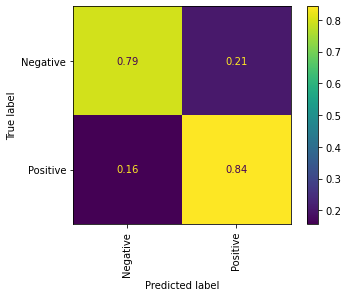

In [86]:
ConfusionMatrixDisplay.from_predictions(ytest, predicted, labels=best_svc_test.classes_, 
                                        xticks_rotation="vertical", normalize="true")

In [87]:
rf_predicted = best_rf_test.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, rf_predicted, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Random Forest:
Precision: 0.44671201814058953
Recall: 0.38266178266178263
F score: 0.3664799253034547


In [88]:
accuracy_score(ytest, rf_predicted)

0.6727272727272727

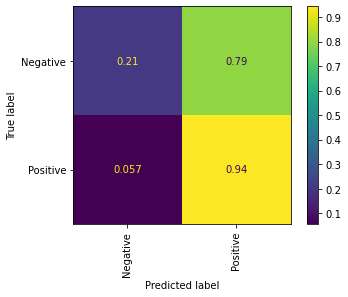

In [89]:
ConfusionMatrixDisplay.from_predictions(ytest, rf_predicted, labels=best_svc_test.classes_, 
                                        xticks_rotation="vertical", normalize="true")